In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 2 Variant
f_0 = 10 * 10**6  # МГц -> Гц
T = 5 * 10**(-6)  # мкс -> c
q = 4 
A = 1

N = 60

dt = 1 / (f_0 * N)
t = np.arange(0, T, dt)

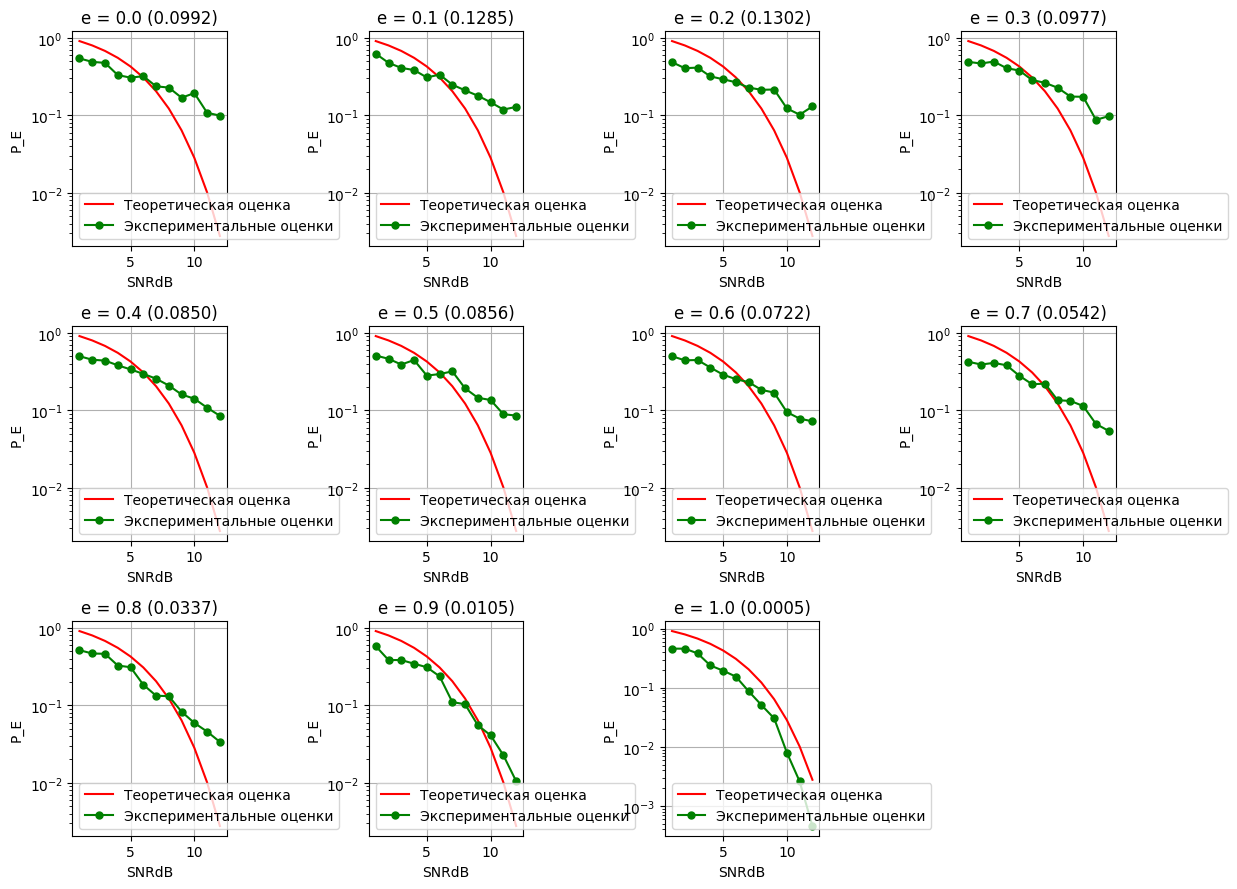

In [4]:
s = np.zeros((q, len(t)))
phi_i_sin = np.zeros((q, len(t)))
phi_i_cos = np.zeros((q, len(t)))
s_i_sin = np.zeros((q, len(t)))
s_i_cos = np.zeros((q, len(t)))

for i in range(q):
    f_i = f_0 + (i - 1) / T
    arg = 2 * np.pi * f_i * t
    s[i, :] = A * np.cos(arg)
    phi_i_sin[i, :] = np.sqrt(2 / T) * np.sin(arg)
    phi_i_cos[i, :] = np.sqrt(2 / T) * np.cos(arg)
    s_i_sin[i, :] = A * np.sin(arg)
    s_i_cos[i, :] = A * np.cos(arg)

SNRdB = np.arange(1, 13, 1)
Pe_t = np.zeros((11, len(SNRdB)))
Pe = np.zeros((11, len(SNRdB)))

Nerrmax = 50
E = np.sum(s * s) / q

plt.figure(figsize=(12, 9))

for idx, epsilon in enumerate(np.arange(0, 1.1, 0.1)):
    for n, SNRdB_val in enumerate(SNRdB):
        SNR = 10 ** (SNRdB_val / 10)
        sigma = np.sqrt(np.sum(E / (2 * SNR)))
        Nerr = 0
        Ntest = 0

        while Nerr < Nerrmax:
            mean_val = np.sqrt(epsilon / 2)
            variance = (1 - epsilon) / 2
            x = np.random.normal(mean_val, np.sqrt(variance))
            y = np.random.normal(mean_val, np.sqrt(variance))

            u = np.sqrt(x**2 + y**2)

            i = np.random.randint(0, q)
            theta = 2 * np.pi * np.random.rand()
            r = (u * np.cos(theta) * s_i_cos[i, :]
                 + u * np.sin(theta) * s_i_sin[i, :]
                 + sigma * np.random.randn(len(s[i, :])))

            r_ci = np.zeros(q)
            r_si = np.zeros(q)

            for j in range(q):
                r_ci[j] = np.trapz(r * phi_i_cos[j, :], t)
                r_si[j] = np.trapz(r * phi_i_sin[j, :], t)

            i_hat = np.argmax((r_ci**2 + r_si**2))

            if i_hat != i:
                Nerr += 1

            Ntest += 1

        Pe[idx, n] = Nerr / Ntest
        SNR = 10**(n / 10)
        N0 = E / SNR

        Pe_t[idx, n] = (q - 1) / 2 * np.exp(-E / (2 * N0))

    plt.subplot(3, 4, idx + 1)
    plt.semilogy(SNRdB, Pe_t[idx, :], 'r-', SNRdB, Pe[idx, :], 'g.-', markersize=10)
    plt.legend(['Теоретическая оценка', 'Экспериментальные оценки'], loc='lower left')
    plt.title(f'e = {epsilon:.1f} ({Pe[idx, -1]:.4f})')
    plt.grid(True)
    plt.xlabel('SNRdB')
    plt.ylabel('P_E')

plt.tight_layout()
plt.show()